In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

import sys
sys.path.append("../src")

import preprocess_data

#### Fake data

In [165]:
sigma_a = 10
sigma_y = 2
a_1 = np.random.normal(100, sigma_a)
a_2 = np.random.normal(90, sigma_a)
y = np.random.normal(a_1 - a_2, sigma_y)

In [136]:
player_1_rank = np.array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 5, 4, 4, 5, 6])
player_2_rank = np.array([2, 2, 2, 1, 1, 1, 4, 4, 3, 1, 3, 4, 4, 2, 2, 1, 6, 3])
y_fake =        np.array([3, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 2, 2, 1, 1, 1, 2, 1])
#y_fake =        np.random.randint(1, 4, len(y_fake))
player_1_white =np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
num_fake_players = len(np.unique(player_1_rank))
prior_fake = np.arange(num_fake_players, 0, -1)
prior_score_fake = (prior_fake - np.mean(prior_fake)) / (2 * np.std(prior_fake, ddof=1))

### Set-up model

In [55]:
model = pystan.StanModel("../stan_models/fake_data_model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8a4acf2ae70e49ddd56ebc95e7c7c0b7 NOW.


In [137]:
stan_data = {
    "num_players": num_fake_players,
    "num_games": len(player_1_rank),
    "K": 3,
    "prior_score": prior_score_fake,
    "player_1_rank": player_1_rank,
    "player_2_rank": player_2_rank,
    "y": y_fake,   
}

In [138]:
fit = model.sampling(data=stan_data)

In [139]:
print(fit)

Inference for Stan model: anon_model_8a4acf2ae70e49ddd56ebc95e7c7c0b7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b            3.4    0.18   2.98  -1.36    1.6   2.95   4.67  11.02    288   1.01
sigma_a     1.88    0.13   1.97   0.05   0.62   1.29    2.4   8.08    244    1.0
c[1]       -0.05    0.02   0.77  -1.48  -0.57  -0.08   0.45   1.51    989    1.0
c[2]        2.12    0.03   0.97   0.52   1.45   2.03   2.71   4.26    825    1.0
raw_a[1]    0.28    0.02   0.81  -1.38  -0.24   0.26    0.8   1.86   1657    1.0
raw_a[2]    0.22    0.02   0.76  -1.39  -0.24   0.24   0.71   1.65   2510    1.0
raw_a[3]   -0.43    0.02   0.81   -1.9  -0.97  -0.45   0.08   1.27   1900    1.0
raw_a[4]   -0.73    0.02   0.73  -2.15   -1.2  -0.74  -0.27    0.8   2051    1.0
raw_a[5]    0.45    0.02   0.81  -1.23  -0.06   0.45   0.97   2.07   2485    1.0
r

In [140]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = arviz.summary(inference_data).reset_index().rename(columns={"index":"parameter"})

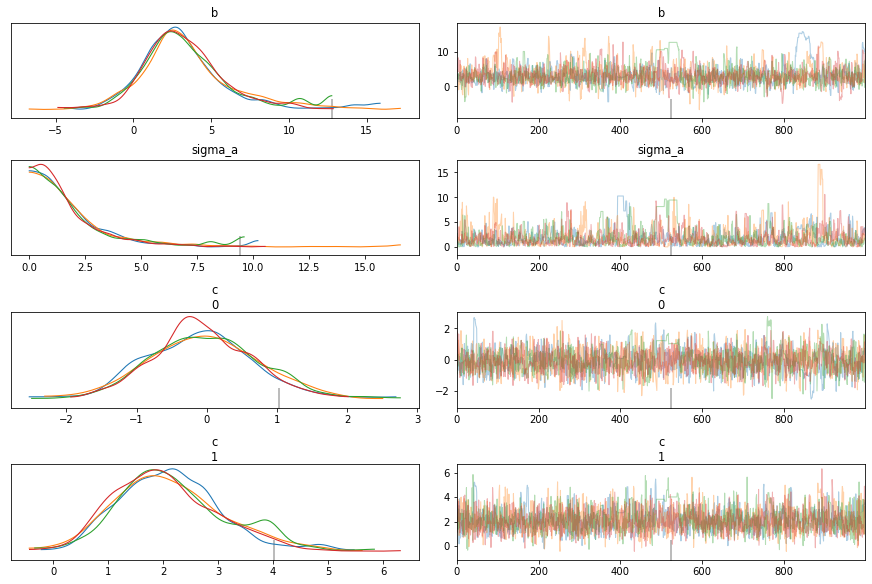

In [141]:
arviz.plot_trace(inference_data, var_names=["b", "sigma_a", "c"]);

### Plotting

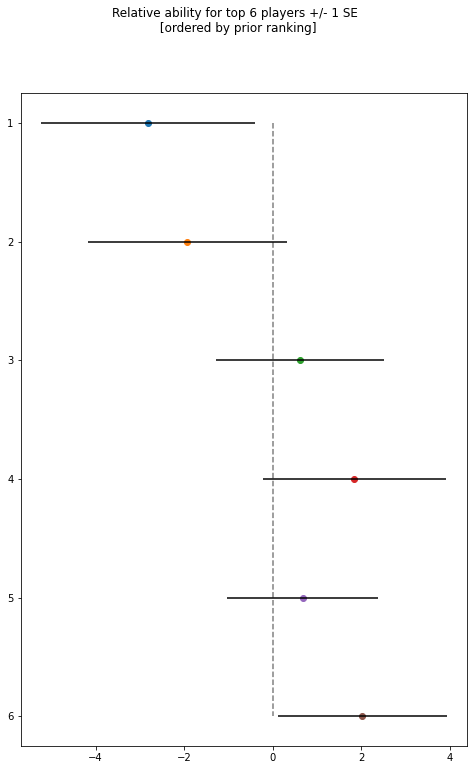

In [109]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = num_fake_players

for i in range(plot_top_n_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();
plt.suptitle(f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]");


In [110]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out/np.mean(out.sum(1))

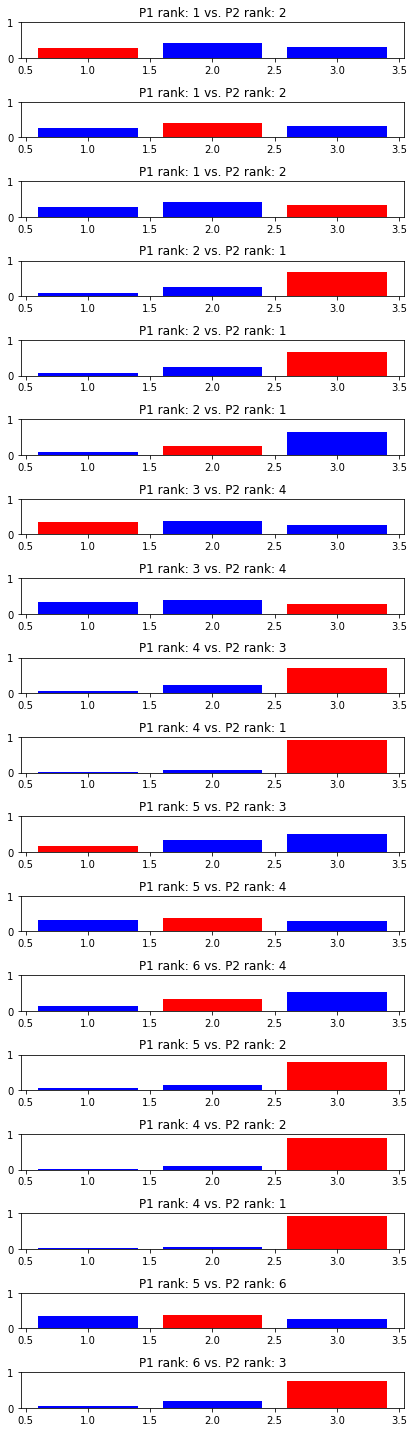

In [111]:
plot_n = len(y_fake)
reverse = False
colors = ["blue"]*3

ranks = [f"P1 rank: {a} vs. P2 rank: {b}" for a, b in zip(player_1_rank, player_2_rank)]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[y_fake[i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors);
    ax[i].set_title(f"{ranks[i]}");
    ax[i].set_ylim(0, 1);
plt.tight_layout();

In [98]:
cls_pred = np.argmax(out_prob, 1) + 1

In [99]:
np.mean(np.abs(y_fake - cls_pred) == 0)

0.6111111111111112

In [100]:
np.mean(np.abs(y_fake - cls_pred) == 1)

0.3333333333333333

In [101]:
np.mean(np.abs(y_fake - cls_pred) == 2)

0.05555555555555555